In [1]:
import requests
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

## **Please Note:**
1. The traffic data is collected from **1st Jan 2008** to **30th Sept 2018** (data for Oct 2018 not published).
2. The traffic data can be expressed in two forms:  
    a. Page counts  
    b. Page views
3. The aggregration is done on a montly basis for desktop and mobile counts/views from the **start** to **end** date.

## Data acquisition:

In [2]:
start = '2008010100'
end =   '2018093000'

# Endpoints for pagecounts (Analytics/AQS/Pageviews) and pageviews (Analytics/AQS/Pageviews)
mobile_counts_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/mobile-site/monthly/'

destop_counts_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/desktop-site/monthly/'

mobile_web_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-web/user/monthly/'

mobile_app_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-app/user/monthly/'

desktop_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/desktop/user/monthly/'

endpoint_dict = {'pagecounts_mobile-site':mobile_counts_url,
                     'pagecounts_desktop-site':destop_counts_url,
                     'pageviews_mobile-web':mobile_web_views_url,
                     'pageviews_mobile-app':mobile_app_views_url,
                     'pageviews_desktop':desktop_views_url}

# Note all jsons will be saved in the form {apiname_accesstype_firstmonth-lastmonth.json} eg: 'pagecounts_desktop-site_200701-201809.json'

In [3]:
# requests the five API endpoints for data between start and end date (montly basis)
for ep_name,ep_url in endpoint_dict.items():
    response = requests.get(ep_url+start+'/'+end)
    if response.ok:
        with open(ep_name+'_'+start[:-4]+'-'+end[:-4]+'.json', 'w') as json_file:
            json_file.write(json.dumps(json.loads(response.content)))
    else:
        print(response.content)

## Data Processing 

In [4]:
# function to load the data from the json files we saved and return a dataframe
def load_dataframe_from_json(json_name):
    df = pd.read_json(json_name)
    df = json_normalize(df['items'])
    
    if 'views' in json_name:
        df['views'].apply(lambda x: int(x))
        df = df.drop(columns=['agent'])
    else:
        df['count'].apply(lambda x: int(x))
    df['year'] = df['timestamp'].apply(lambda x: x[:4])
    df['month'] = df['timestamp'].apply(lambda x: x[4:6])
    df = df.drop(columns=['timestamp','granularity','project'])
    return df

In [5]:
# we will store the processed dataframes in a list
df_list = []

for ep_name,ep_url in endpoint_dict.items():
    json_name = ep_name+'_'+start[:-4]+'-'+end[:-4]+'.json'
    # eg: 'pagecounts_desktop-site_20080101-20181014.json'
    df = load_dataframe_from_json(json_name)
    df_list.append(df)

In [6]:
# we add mobile-app and mobile-web and delete one of them
df_list[2]['views'] = df_list[2]['views'] + df_list[3]['views']
df_list[2]['access'] = 'mobile'
del df_list[3]

In [7]:
# merge all the dataframes into one major list of lists and then a single dataframe
list_formatted = []
i = 0
val_dict = {'pagecount_mobile_views':0, 'pagecount_desktop_views':0, 'pageview_mobile_views':0, 'pageview_desktop_views':0}

for year in np.arange(2008, 2019):
    for month in np.arange(1,13):
        
        y = str(year)
        m = str(month) if month>9 else '0'+str(month)
        
        for i in range(len(df_list)):
            found_index = df_list[i].loc[(df_list[i]['year'] == y) & (df_list[i]['month'] == m)]
            if found_index.empty:
                val_dict[list(val_dict.keys())[i]] = 0
            else:
                val_dict[list(val_dict.keys())[i]] = found_index.iloc[0][1]
    
        list_formatted.append([y, m, val_dict['pagecount_mobile_views']+val_dict['pagecount_desktop_views'], val_dict['pagecount_desktop_views'], val_dict['pagecount_mobile_views'], val_dict['pageview_mobile_views']+val_dict['pageview_desktop_views'], val_dict['pageview_desktop_views'], val_dict['pageview_mobile_views']])

In [8]:
# convert list of lists to dataframe
df_formatted = pd.DataFrame(list_formatted, columns=['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views'])

In [9]:
# remove extra months from 2018 
df_formatted = df_formatted[:-3]
# preview dataframe (first 10 records)
df_formatted.head(10)

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,863575077,863575077,0,0,0,0
1,2008,02,805618770,805618770,0,0,0,0
2,2008,03,821957233,821957233,0,0,0,0
3,2008,04,844357513,844357513,0,0,0,0
4,2008,05,827713709,827713709,0,0,0,0
5,2008,06,825055354,825055354,0,0,0,0
6,2008,07,780369890,780369890,0,0,0,0
7,2008,08,804302071,804302071,0,0,0,0
8,2008,09,817672904,817672904,0,0,0,0
9,2008,10,855432765,855432765,0,0,0,0


In [10]:
# saving dataframe to a csv file
df_formatted.to_csv('en-wikipedia_traffic_200801-201709.csv',index=False)

## Analysis

The data is then visualized for mobile, desktop and total views on a monthly basis

In [11]:
df_formatted['date'] = df_formatted['year'] +"-"+ df_formatted['month'] + "-01"

In [12]:
timeseries_list = [(df_formatted['pagecount_all_views']+df_formatted['pageview_all_views']).tolist(), (df_formatted['pagecount_desktop_views']+df_formatted['pageview_desktop_views']).tolist(), (df_formatted['pagecount_mobile_views']+df_formatted['pageview_mobile_views']).tolist()]

ts = pd.DataFrame(np.array(timeseries_list).T, index=pd.date_range(start='2008-01-01', end='2018-10-01', freq='M'), columns=['all_views','desktop_views','mobile_views'])

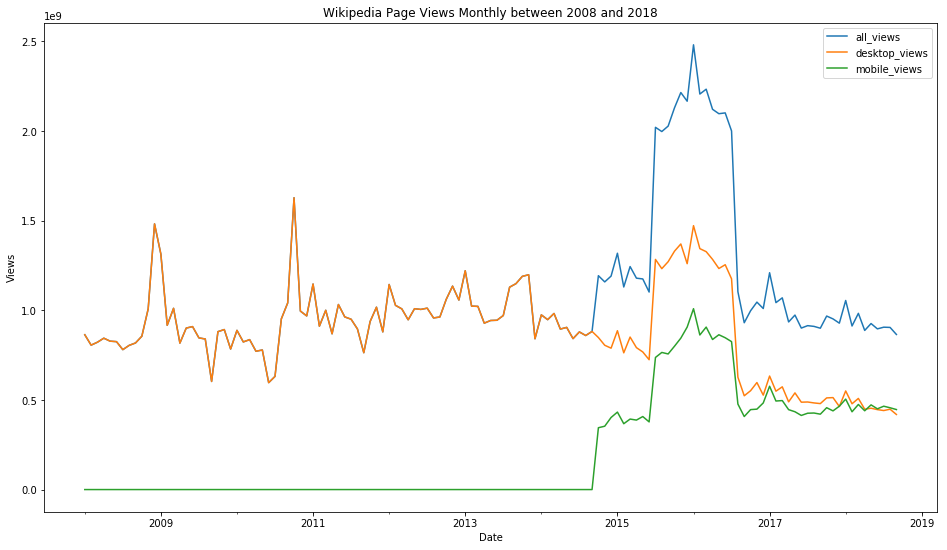

In [13]:
axes = ts.plot(title='Wikipedia Page Views Monthly between 2008 and 2018')
axes.set_xlabel("Date")
axes.set_ylabel("Views")
fig = axes.get_figure()
fig.set_size_inches(16, 9)
# plt.savefig('wikipedia_pagevies_monthly.png')

Obviously we can see that just adding pageviews and pagecounts causes a sudden jump in values somewhere around 2016. This is the duration of overlap after pageviews were introduced and pagecounts was made lagacy.

Let us now go ahead and see this data without adding them. i.e. Pagecounts and Pageviews separately for desktop, mobile and both. The sudden dip or difference between values from pagecounts to pageviews can be attributed to the filteration of web crawlers or spiders.

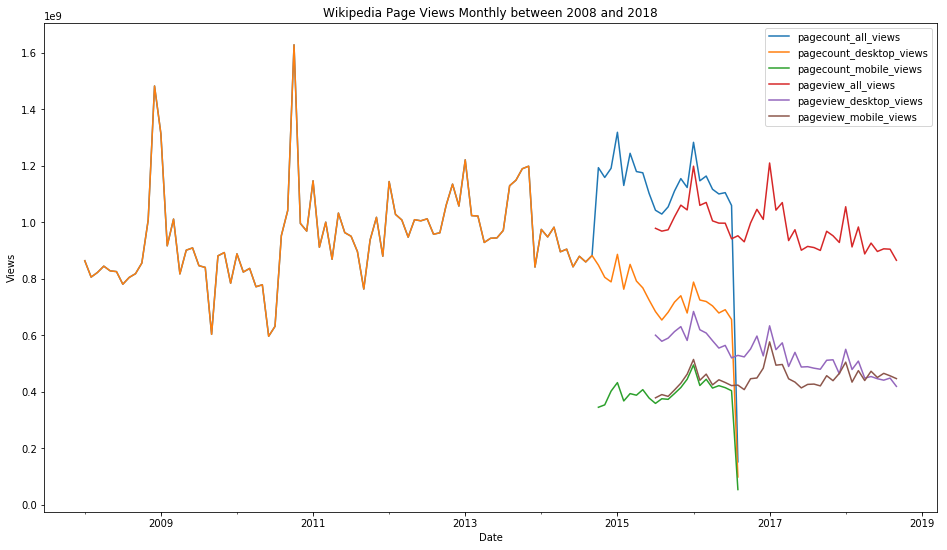

In [14]:
df_formatted.index = pd.date_range(start='2008-01-01', end='2018-10-01', freq='M')

axes = df_formatted.replace(0, np.nan).plot(title='Wikipedia Page Views Monthly between 2008 and 2018')
axes.set_xlabel("Date")
axes.set_ylabel("Views")
fig = axes.get_figure()
fig.set_size_inches(16, 9)
plt.savefig('wikipedia_pagevies_monthly.png')